# Setting the stage

Training a network for generating captions from images is quite a herculean task if one has to do everything from scratch. 

We are blessed with a lot of predefined helper functions to easily implement a number of tasks. We are going to use them. Let's import them.

I've mentioned a comment as to why every import is crucial and what function it serves.

In [ ]:
# To get the image and caption data from Google Drive.
from google.colab import drive

# For preprocessing captions and storing them in 
# memory as dictionaries
from collections import defaultdict, Counter

# To navigate across folders and accessing data
import os

# To return a stack trace of errors if something goes wrong in GPU Computations
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# For preprocessing captions
import string
import random
import re

# For matrix and math operations
import numpy as np
import math

# For formatting output while viewing training logs
import sys
import pandas as pd

# To compute the time required for training a 
# batch, an epoch etc.
import time

# To build, train and save NN architectures for caption generation
import torch
import torchvision.transforms as tfms

# To define our own Dataset Class and dataloader instance
import torch.utils.data as data

# To read and resize images
from PIL import Image

# To convert images from numpy arrays or PIL Images to 
# Tensor representations
import torchvision.transforms.functional as TF

# To build layers of a Neural Network architecture
import torch.nn as nn

# To import pretrained model Resnet50 trained on ImageNet
# data for encoding images 
import torchvision
import torchvision.models as models

# To call operators like activation functions etc. while 
# implementing the forward pass behavior
import torch.nn.functional as F

# To validate the output captions against any one input
# Set of captions
from nltk.translate.bleu_score import sentence_bleu

# To plot images in notebook
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Import the encoder and decoder classes from model.py file
from helper_functions import clean_caption, read_txt

In [ ]:
import torchvision
torchvision.models.resnet.model_urls['resnet50'] = torchvision.models.resnet.model_urls['resnet50'].replace('https://', 'http://')

In [ ]:
!nvidia-smi

Wed Feb 19 15:09:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Captions

Every image has five captions which are provided in a text file in the following structure.

>1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

>1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

>1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse 

The general structure is of the form 

**\<img_name\>\<#\>\<captionnumber\> \<caption\>**

Utilize this structure information and create a dictionary with image name as the key and a list of captions associated with that image as the value.



In [ ]:
# Define a dictionary to hold all the captions
description = defaultdict(lambda: [])
tokens = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt'

In [ ]:
# Read all the captions into a list "captions"
captions = []
with open(tokens, 'r') as op:
  captions = op.readlines()

## Cleaning the captions

There are some operations we need to perform before we store the captions.

- Convert all caption words to lowercase. We do not care for casing here. A lowercase `a` and an uppercase `A` are the same semantically for the sake of this task.

- Punctuations don't mean anything. The descriptions are supposed to be short and objective in nature. Punctuations do not add any value in that aspect since they're used to convey other lingual information like pauses or emotions or tone which is out of scope of this task.

In [ ]:
captions = [re.sub('\t', ' ', i) for i in captions]
captions = [re.sub('\n', ' ', i) for i in captions]
all_caps = []
# Make a dictionary to hold captions wrt every image
# Key - Image, Value - Captions

for item in captions:
  key = re.findall(r'(.+)#\d', item)[0]
  caption = re.findall(r'.+#\d (.+)', item)[0]
  caption = clean_caption(caption)
  description[key].append(caption)
  all_caps.append(caption)

## Selecting appropriate sentence length.

The histogram below expresses the length of captions. It can be seen that most of the captions have a sentence length of around $10 \pm 5$. 

Since we're training a neural network based architecture, we have to make sure to keep the length of our input fixed. Now, since we have captions of varying lengths, we will have to manually add padding to some captions to get them to be of a standard length.

This standard length can simply be the length corresponding to the longest caption. However, in that case, we'll have to bear a big overhead of large sequences which will take more time for training. We can experiment with several other lengths and come to a standard length by looking at the average training time of a batch and tuning this sentence length parameter. 

I started with a value of 10 and increased the length in steps of 2. I found 10 to be a good length based on the above criterion and I chose to go with it. You can experiment and find out what suits your requirement and accordingly decide.

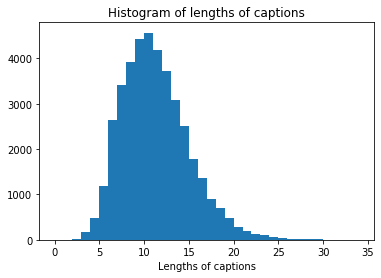

In [ ]:
# Find out the lengths of sentences in these captions and create a histogram
# To visualize 

lens = [len(cap.split(' ')) for cap in all_caps]
plt.hist(lens, bins = range(0, max(lens)));
plt.xlabel('Lengths of captions')
plt.title('Histogram of lengths of captions')
plt.savefig('Histogram.PNG')

## Adding markers to captions.

For every caption, there's at least two tags that we need to add in order to make the decoder work. These are respectively the start and end tokens.

After an image is input to the model, it needs to predict "start" and then the caption and eventually predict "end" when the sequence ends.

To encorporate this, we will take the caption, add these tokens and even after doing so, if some length of the caption is yet to be filled, then we'll add padding to make them all captions of uniform length as expected by the decoder. Captions which exceed length 10 will be terminated abrubptly and an end token will be appended after slicing the caption with length = 10.



In [ ]:
# We will consider only captions with length 18 or less.
# Any less number of words, we'll pad it to make it a length 10 caption
# Any more number of words, we'll truncate it to make a length 10 caption

# Append every seq with startseq at beginning
# And endseq at the end for the sake of identifying the start and end of the caption
# Pad up the remaining portion of caption with other if it's length is less than 10

caption_length = 10

for key, caps in description.items():
  revised_captions = []
  for caption in caps:
    l = caption.split(' ')
    if len(l) >= caption_length:
      l = ['<startseq>'] + l[:caption_length] + ['<endseq>']
    elif len(l) < caption_length:
      l = ['<startseq>'] + l + ['<endseq>'] +['<0>']*(caption_length - len(l)) 
    revised_captions.append(' '.join(l)) 
  description[key] = revised_captions

In [ ]:
# Extract all words from the captions
all_words = ' '.join(all_caps).split(' ')
all_unique_words = set(all_words)
len(all_unique_words)

8775

## Thresholding words

In the decoder layer, we have several number of embeddings which need to be learned to represent the words in the form of an n-dimensional vector. The more these embeddings, the more the learning and computational overhead. 


In the captions, we can see that there's several words which have only appeared once or twice i.e. a very small number of times. Although it may be very relevent to associate that word with that image,

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/450px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg)

(**what else can you call this**) but because it has only one instance that it's associated with (eg. Monalisa only appears once in the corpus with this image's caption), the embedding learned to represent that word will not be so great and it may lead to poor performance.

So, let's threshold the words to only include those ones which have appeared at least twice in the entire corpus of captions which is quite reasonable.


In [ ]:
# Extract all unique words from captions which occur at least
# A certain number of times (Threshold)
c = dict(Counter(all_words))
Threshold = 2
words = {key:val for key, val in c.items() if val > Threshold}
len(words)

4079

In [ ]:
# Obtain which image belongs to what class
train_images_names = read_txt('/content/drive/My Drive/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt')
validation_images_names = read_txt('/content/drive/My Drive/flicker8k-dataset/Flickr8k_text/Flickr_8k.devImages.txt')
test_images_names = read_txt('/content/drive/My Drive/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt')

## Mapping words to integer indices

Neural Networks do not understand anything other than numbers. We cannot feed them strings and expect them to churn out meaningful output. We have to represent our strings as integer indices before passing them to the network.

For the sake of this, let's create two dictionaries. One that maps every word in the words set to an integer and another that maps every integer back to the word it represents.

Note that there's a provision for 4 special words which do not appear in the text corpus provided to us whcih we're artificially going to introduce.

- 0 - It is there for padding the captions which are short to a suitable length.
- 1 - It represents the start of a caption.
- 2 - It represents the end of a caption.
- 3 - Note that since we've truncated some words from our bag of words, we have to substitute an approporiate placeholder to represent these words. That is done by a word called `<other>`. This index is reserved for them.



In [ ]:
# Reserve 0, 1, 2, 3 for padding, start sequence, end sequence and other words
# Create a mapping between word to index and index to word respectively
word_to_ix = {}
ix_to_word = {}
for j, word in enumerate(words):
  word_to_ix[word] = j + 4
  ix_to_word[j + 4] = word

In [ ]:
word_to_ix['<other>'] = 3
word_to_ix['<endseq>'] = 2
word_to_ix['<startseq>'] = 1
word_to_ix['<0>'] = 0

ix_to_word[0] = '<0>'
ix_to_word[1] = '<startseq>'
ix_to_word[2] = '<endseq>'
ix_to_word[3] = '<other>'

In [ ]:
tokenized_descriptions = {}

for key, captions in description.items():
  revised_captions = []
  for caption in captions:
    tokenized_caption = []
    tokens = caption.split(' ')
    
    for token in tokens:
      if token in word_to_ix.keys():
        tokenized_caption.append(word_to_ix[token])
      else:
        tokenized_caption.append(word_to_ix['<other>'])
    
    revised_captions.append(tokenized_caption)
  tokenized_descriptions[key] = revised_captions    

In [ ]:
# Segregate the data based on type of dataset
def get_dataset(instances = train_images_names):
  d = {}
  for im in instances:
    if im in tokenized_descriptions.keys():
      d[im] = tokenized_descriptions[im]
  return d  

In [ ]:
train = get_dataset(train_images_names)
test = get_dataset(test_images_names)
validation = get_dataset(validation_images_names)

In [ ]:
print(f"Number of instances in train data: {len(train)}")
print(f"Number of instances in test data: {len(test)}")
print(f"Number of instances in validation data: {len(validation)}")

Number of instances in train data: 6000
Number of instances in test data: 1000
Number of instances in validation data: 1000


# Define a custom dataloader

Now that both the images and captions are ready and processed, we can proceed with defining a loader object to iteratively get batches of the same and work for it. 

Pytorch provides a good way to do this. We can inherit the Dataset class from torch.utils.data package and define how we want to churn out a single data instance and couple it with the Dataloader class of the same object to retrieve data iteratively.

Dataloaders are generator objects which are quite awesome in the respect that because of them we can get batches of images and captions. We don't have to hold everything in memory which makes this datastructure highly useful for efficient memory management.

In [ ]:
# Create a dictionary that holds the names of all images in train
# And test datasets
partition = {}
partition['train'] = train_images_names
partition['test'] = test_images_names
partition['validation'] = validation_images_names

# Create a copy of the tokenized descriptions dictionary
# and use it in datasets for extracting caption for images.
labels = tokenized_descriptions.copy()

In [ ]:
class ImageDataset(data.Dataset):
  
  def __init__(self, ids, labels, img_folder, transform = None, resize = 299, mode = "Train"):

    self.labels = labels
    self.ids = ids
    self.img_folder = img_folder
    self.transform = transform
    self.resize = resize
    self.mode = mode

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    id_ = self.ids[index]
    
    # Read the image, convert to RGB image
    # Change it's size in order to make sure the input
    # To network is consistently sized.
    orig_img = Image.open(self.img_folder + '/' + id_)
    orig_img = orig_img.convert('RGB')
    
    if self.transform:
      proc_img = self.transform(orig_img)
    else:
      proc_img = orig_img.resize((self.resize, self.resize))
      proc_img = TF.to_tensor(proc_img)
      proc_img = proc_img.type(torch.FloatTensor) 
    
    y = random.sample(self.labels[id_], 1)[0]
    y = torch.tensor(y, dtype = torch.int64)
        
    if (self.mode == "Train") or (self.mode == "Validation"):
      # Get any one caption out of the five captions
      # Associated with the image and use it for training
      return (proc_img, y)

    elif self.mode == "Test":
      orig_img = TF.to_tensor(orig_img)
      orig_img = orig_img.type(torch.FloatTensor)
      return (orig_img, proc_img, y)

In [ ]:
# If a GPU is available for the computations, use it.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transforms = tfms.Compose([tfms.RandomHorizontalFlip(p = .1),
                           tfms.RandomVerticalFlip(p = .1),
                           tfms.Resize(size = (299, 299)),
                           tfms.RandomRotation(degrees = 15),
                           tfms.ToTensor(),
                           tfms.Normalize((0.485, 0.456, 0.406),
                                          (0.229, 0.224, 0.225))])

val_loader_parameters = {'batch_size':64,
                         'shuffle':True}

trainloader_parameters = {'batch_size':20,
                         'shuffle':True}

testloader_parameters = {'shuffle':True}

In [ ]:
# Dataloaders

# Train Generator
training_set = ImageDataset(ids = partition['train'], labels = labels, img_folder =  '/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset/Train',
                            transform = transforms, mode = 'Train')
training_generator = data.DataLoader(training_set, **trainloader_parameters)

# Validation Generator
validation_set = ImageDataset(partition['validation'], labels, '/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset/Validation',
                              transform = transforms, mode = "Validation")
validation_generator = data.DataLoader(validation_set, **val_loader_parameters)

# Test Generator
test_set = ImageDataset(ids = partition['test'], labels = labels, img_folder = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset/Test',
                        transform = transforms, mode = "Test")
test_generator = data.DataLoader(test_set, **testloader_parameters)

# Model Training

Both the encoder and decoder are defined in the model.py file in the current working directory. 

*Architecture*:

The CNN Encoder is a ResNet50 pretrained model whose architecture is as follows:

<img src="https://cv-tricks.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png" width=35%>



The encoder grabs the last but one layer from the above model. The final layer is a 1000 class classification layer which we're not interested in. We're only interested in extracting the general hierarchies of information in an image. So, grab the penultimate layer and for the sake of making the output of a CNN Encoder homogeneous with the embeddings of the words in our caption, we stick a linear layer on top of this CNN with output equal to the embedding dimensions.

Next we have an Recurrent network with LSTM Cells in place to handle the captions. This RNN Decoder is comprised of three layers:

- A Word Embedding layer with num_embeddings = size of the captions vocabulary and output dimensions same as the output dimensions of the CNN Encoder i.e. embed_size.
- An LSTM Layer with hidden_size as it's number of output neurons and embed_size as it's input neurons. An argument for dropout is provided if in case we're required to use more than one LSTM layer i.e. num_layers > 1.
- A linear layer which accepts input from the LSTM layer and maps every input to a vocab_size number of neurons in the output. This output layer could be thought of as a probability distribution of all those words in our vocabulary and we pick the one with the highest value as our output word.

The weights of the model are only modified until the top of the CNN i.e. the newly introduced Linear Layer and not any further. The Resnet50 architecture is kept intact. Let's review the hyperparameters of our model.

*Hyperparameters*:

[This paper](https://arxiv.org/pdf/1411.4555.pdf) systematically lists down the findings on a neural image caption generator and in section 4.3.1, they've mentioned the following hyperparameters which I have used in my architecture as well.

![Neural Image Captioning Paper](Hyper_params.PNG)

I experimented with several batch sizes [10, 12, 16, 20] and thought 16 was a decent size based on the training observations. With 10 the training loss was quite fluctuating but with 16, although it did fluctuate, the extent of deviation had gone down. With a small batch size, the outlierish points tend to sway the weight updates away from the local minimum to a larger extent. That is relatively less when it comes to a higher **batch_size, hence 16**. Since the model takes a lot of time to train, I restricted the **number of epochs to a modest 3**.

In [ ]:
# Constants for the network that has to be trained below
embed_size = 200
hidden_size = 256
num_epochs = 20
periodic_check = 75

In [ ]:
# Get the vocab size for embedding layer
# 4 for 0, startseq, endseq, other and one for out of vocabulary token
vocab_size = len(words) + 5
vocab_size

4084

## Load weights from glove vector embeddings

In [ ]:
lines = []
with open('/content/drive/My Drive/glove.6B.200d.txt', 'r') as op:
  lines = op.readlines()

In [ ]:
dict_words = list(word_to_ix.keys())

In [ ]:
glove_vectors = np.random.randn(vocab_size, embed_size)

In [ ]:
glove_words = []
counter = 0
# glove_vectors = np.array(len(lines), embed_size)
for line in lines:
  line = re.sub('\n', '', line)
  everything = line.split(' ')
  
  word = everything[0]
  weights = everything[1:]
  weights = np.array([np.float(i) for i in weights], dtype = 'float')

  if word in word_to_ix.keys():
    counter = counter + 1
    index = word_to_ix[word]
    glove_vectors[index] = weights

# Encoder CNN Class Definition

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad_(False)
    
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.embed = nn.Linear(resnet.fc.in_features, embed_size)

  def forward(self, images):
    features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.embed(features)
    return features

# Decoder RNN Class Definition

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout_prob = 0.1, weights = None):      
    super(DecoderRNN, self).__init__()
    # Make a note of all the architecture variables. They might come in handy at a later stage
    print("Initializing Decoder...")
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers
    self.drop = dropout_prob
    self.glove_embedding_weights = torch.FloatTensor(weights)
    
    # Create a flag to see the shape of tensors for only one forward pass
    self.view_tensor_flow = True
    self.view_predict_tensor_flow = True
    
    # Embedding Layer - Create an embedding layer as big as the size of your vocabulary and map each word to a 
    # vector of length embed_size
    self.embedding = None
    if not (weights is None):
      print('Loading Glove Weights')
      weights = torch.FloatTensor(weights)
      self.embedding = nn.Embedding.from_pretrained(weights)
    else:
      self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_size)
    
    self.embedding.weight.requires_grad = True
    
    # LSTM Layer
    if num_layers > 1:
      self.LSTM_layer = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers, 
                                  dropout = dropout_prob, batch_first = True)
    else:
      self.LSTM_layer = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers,
                                  batch_first = True)
        
    
    # Linear Output layer - Accepts the LSTM output and does a prediction to map the LSTM output to 
    # a probability value for each and every word in our vocab.
    # self.fc = nn.Linear(in_features = hidden_size, out_features = hidden_size * 2)
    self.fc = nn.Linear(in_features = hidden_size, out_features = vocab_size)
    
  def forward(self, features, captions):
    batch_size = features.shape[0]
    seq_length = captions.shape[1]
    
    # Since we're not passing the last token in our sequence remove that
    # from our captions. We want to predict the next item given prev item
    captions = captions[:batch_size, :(seq_length - 1)]
    seq_length = captions.shape[1]
    
    # Now, engage your gears of attention!
    # First get the embeddings for captions. It's dimensions will be - batch_size x seq_length x embed_size
    captions_embedded = self.embedding(captions)
    
    # The embedding_size for a word in a caption is the same as
    # The CNN Encoder output vector dimension. So, basically, Number of neurons in the Resnet modified encoder output layer 
    # is the same as the number of neurons in the embedding layer of the individual words in a caption
    # Therefore define the image_size accordingly so as to concatenate with the captions
    image_resized = features.unsqueeze(1)
    
    # Create a container to hold the output words
    output_words = []


    # Define a hidden state to be of random numbers for first iteration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden = torch.randn(self.num_layers, batch_size, self.hidden_size).to(device)
    cell = torch.randn(self.num_layers, batch_size, self.hidden_size).to(device)
    state = (hidden, cell)
    
    # Iterate for one more than seq_length number of times. Predict a word using image + word
    # Image + two words, Image + three words, Image + Four Words and so on and store the predicted
    # Word in output words 
    for iteration in range(seq_length + 1):

      LSTM_input = None
      
      if iteration == 0:
        LSTM_input = image_resized
      elif iteration == 1:
        word = captions_embedded[:, 0, :].unsqueeze(1)
        LSTM_input = torch.cat((image_resized, word), 1)
      elif iteration > 1:
        words = captions_embedded[:, :iteration, :]
        LSTM_input = torch.cat((image_resized, words), 1)

      LSTM_output, state = self.LSTM_layer(LSTM_input, state)

      last_word = LSTM_output[:,-1,:].unsqueeze(0)
      out = self.fc(last_word)
      output_words.append(out)
    
    # Concatenate all the words that are generated in the process and return them as output
    final_output = torch.cat(output_words, 0).transpose(0, 1)
    
    if self.view_tensor_flow:
      print(f"Shape of incoming features: {features.shape}")
      print(f"Shape of incoming captions: {captions.shape}")
      print(f"Batch Size: {batch_size}, Sequence Length: {seq_length + 1}")
      print(f"Shape of captions after embedding: {captions_embedded.shape}")
      print(f"Shape of features altered to concat with captions: {image_resized.shape}")
      print(f"Hidden state shape: {state[0].shape}, Cell state shape: {state[1].shape}")
      print(f"Shape of output: {final_output.shape}\n\n")
      self.view_tensor_flow = False
    return final_output
      

  def sample(self, inputs, states=None, max_len=13):
    " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
    # Create an empty list to hold all the indices for words of a sentence
    words = []
    caption_embeddings = None
    embedded_word = None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if (states is None):
      h = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
      c = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
      states = (h, c)

    # Implement the forward pass to get the first word
    word1_, states = self.LSTM_layer(inputs, states)
    
    # Get the word out of this forward pass
    out_ = self.fc(word1_)
    
    # Output word
    out_word = torch.argmax(out_, dim = 2).item()
    words.append(out_word)
    caption_embeddings = self.embedding(torch.tensor([out_word]).to(device).unsqueeze(1))
    # Now feed these words recursively in a for loop to generate words
    
    for i in range(max_len - 1):
      features = torch.cat((inputs, caption_embeddings), 1)
      
      # Feed this as input to the LSTM layer        
      LSTM_out, states = self.LSTM_layer(features, states)
      
      # Feed the output to a linear layer
      last_word = LSTM_out[:,-1,:].unsqueeze(0)
      # last_word = LSTM_out
      lin_out = self.fc(last_word)
      
      # Apply the softmax activation function on the output of linear pass
      word_index = torch.argmax(lin_out, dim = 2).item()
      words.append(word_index)
      embedded_word = self.embedding(torch.tensor([word_index]).to(device).unsqueeze(1))
      caption_embeddings = torch.cat((caption_embeddings, embedded_word), 1)
        
    if self.view_predict_tensor_flow:
      print(f"\nOriginal Input shape: {inputs.shape}")
      print(f"LSTM 1st Word Output shape: {word1_.shape}")
      print(f"Output shape: {out_.shape}")
      print(f"Caption Embeddings Shape: {caption_embeddings.shape}")
      print(f"Last Embedded word shape: {embedded_word.shape}")

      self.view_predict_tensor_flow = False  
    
    return words

In [ ]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, weights = glove_vectors)

Downloading: "http://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Initializing Decoder...
Loading Glove Weights


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [ ]:
# Define the learnable parameters
params = list(decoder.parameters()) + list(encoder.embed.parameters())

In [ ]:
# Define the optimizer.
optimizer = torch.optim.Adam(params, lr = 9e-3)

In [ ]:
# Find out the total number of batches that you're gonna train for
# By dividing the total number of samples by the batch size
total_steps = math.ceil(len(training_generator.dataset.ids) / training_generator.batch_size)
print(total_steps)

300


In [ ]:
decoder.load_state_dict(torch.load('/content/drive/My Drive/decoder_temp_image_greedy_glove.pkl'))
encoder.load_state_dict(torch.load('/content/drive/My Drive/encoder_temp_image_greedy_glove.pkl'))

<All keys matched successfully>

In [ ]:
# Move models to GPU if CUDA is available. 
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding): Embedding(4084, 200)
  (LSTM_layer): LSTM(200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4084, bias=True)
)

In [ ]:
def validate_model():
  num_batches = math.ceil(len(validation_generator.dataset.ids) / validation_generator.batch_size)
  torch.set_grad_enabled(False)
  total_loss = 0

  for batch in range(num_batches):
    valid_images, valid_captions = next(iter(validation_generator))
    valid_images = valid_images.to(device)
    valid_captions = valid_captions.to(device)

    valid_image_features = encoder(valid_images)
    output = decoder(valid_image_features, valid_captions)

    loss = criterion(output.reshape(-1, vocab_size), valid_captions.reshape(-1))
    total_loss += loss.item()
  
  average_validation_loss = total_loss / num_batches
  torch.set_grad_enabled(True)
  return average_validation_loss

In [ ]:
# Training Process
training_log = []
validation_loss_history = []
num_batches = total_steps

torch.set_grad_enabled(True)
encoder.train()
decoder.train()
decoder.view_tensor_flow = True

for epochs in range(1, num_epochs+1):
  
  batch_train_time = 0
  # Adapt the learning rate
  if epochs >= 7:
    optimizer = torch.optim.Adam(params, lr = 5e-3)
  elif epochs >= 10:
    optimizer = torch.optim.Adam(params, lr = 1e-3)
  elif epochs >= 13:
    optimizer = torch.optim.Adam(params, lr = 9e-4)
  
  epoch_loss = 0  
  # Actual Training loop
  for step in range(num_batches):
    start = time.time()
    train_images, train_captions = next(iter(training_generator))

    # Move to cuda if GPU is available
    train_images = train_images.to(device)
    train_captions = train_captions.to(device)

    # Reset the gradients else they'll get accumulated
    encoder.zero_grad()
    decoder.zero_grad()

    # Forward Pass
    image_features = encoder(train_images)
    output = decoder(image_features, train_captions)

    # Find the batch loss
    # Output is in the shape bs X seq_len X embedding
    # For calculation of loss, we need to reshape the arrays for comparison
    if step == 0 and epochs == 1:
      print(f"The shape of adjusted output (for loss calc): {output.reshape(-1, vocab_size).shape}")
      print(f"The shape of adjusted caption (for loss calc): {train_captions.reshape(-1).shape}\n")
    loss = criterion(output.reshape(-1, vocab_size), train_captions.reshape(-1))
    
    # Backpropogate the loss
    loss.backward()

    # Update the parameters in the optimizer
    optimizer.step()

    # Get the statistics about network learning
    ep = epochs
    current_step = "{0:>5}".format(step + 1)
    numerical_loss = "{0:>7}".format(np.round(loss.item(), 5))
    epoch_loss += float(numerical_loss)

    # Get the statistics about time i.e. avergae batch completion time and epoch completion time
    curr_batch_training_time = np.round(time.time() - start, 2)
    batch_train_time += curr_batch_training_time
    avg_batch_train_time = "{0:>5}".format(np.round(batch_train_time / (1 + step), 3))
    expected_remaining_time = "{0:>5}".format(np.round(float(avg_batch_train_time) * (num_batches - step), 2))

    avg_batch_loss = "{0:>7}".format(np.round(epoch_loss / (1 + step), 5))
    

    # Display the statistics mentioned above in output.
    measures = f"Epoch: {ep}/{num_epochs}, Batch: {current_step}/{num_batches}, Avg Batch Loss: {avg_batch_loss}, Current Batch Loss: {numerical_loss}, Average Batch Train Time: {avg_batch_train_time}s, Time remaining for Epoch: {expected_remaining_time}s"
    print(f'\r{measures}', end = "")
    sys.stdout.flush()

    if (step) % periodic_check == 0:
      print(f'\r{measures}')
      
      entry = {'Epoch': int(ep), 'Batch': int(current_step), 'Loss': float(avg_batch_loss), 'Btch Train Time': float(avg_batch_train_time)}
      training_log.append(entry)
      
    
    # Save the model with weights after every periodic check batches
    if (1 + step) % periodic_check == 0:
      torch.save(decoder.state_dict(), os.path.join('/content/drive/My Drive', f'decoder_temp_image_greedy_glove.pkl'))
      torch.save(encoder.state_dict(), os.path.join('/content/drive/My Drive', f'encoder_temp_image_greedy_glove.pkl'))
    
  valid_loss = "{0:>4}".format(np.round(validate_model(), 4))
  print(f"\nAt the end of epoch {ep}, validation loss: {valid_loss}\n")
  validation_loss_history.append(valid_loss)

Shape of incoming features: torch.Size([20, 200])
Shape of incoming captions: torch.Size([20, 11])
Batch Size: 20, Sequence Length: 12
Shape of captions after embedding: torch.Size([20, 11, 200])
Shape of features altered to concat with captions: torch.Size([20, 1, 200])
Hidden state shape: torch.Size([1, 20, 256]), Cell state shape: torch.Size([1, 20, 256])
Shape of output: torch.Size([20, 12, 4084])


The shape of adjusted output (for loss calc): torch.Size([240, 4084])
The shape of adjusted caption (for loss calc): torch.Size([240])

Epoch: 1/20, Batch:     1/300, Avg Batch Loss: 8.35454, Current Batch Loss: 8.35454, Average Batch Train Time:  0.42s, Time remaining for Epoch: 126.0s
Epoch: 1/20, Batch:    76/300, Avg Batch Loss: 3.90448, Current Batch Loss: 3.31049, Average Batch Train Time: 0.362s, Time remaining for Epoch: 81.45s
Epoch: 1/20, Batch:   151/300, Avg Batch Loss: 3.54507, Current Batch Loss: 2.91247, Average Batch Train Time: 0.364s, Time remaining for Epoch:  54.6s
E

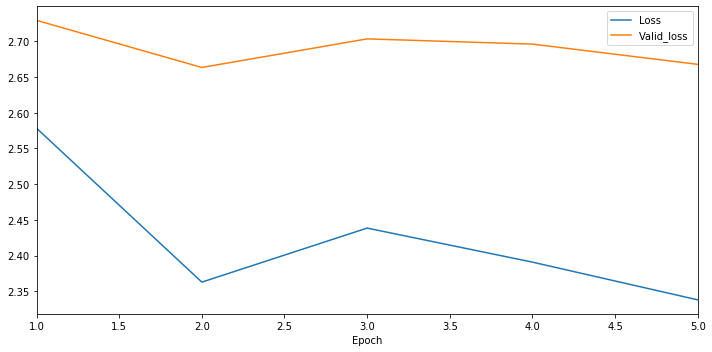

In [ ]:
import pandas as pd
log = pd.DataFrame(training_log)
log = log.groupby(by = ['Epoch']).mean()
log['Valid_loss'] = [float(i) for i in validation_loss_history]

fig, ax = plt.subplots(1, 1, figsize = (10,5))
log.plot(y = 'Loss', kind = 'line', ax = ax)
log.plot(y = 'Valid_loss', kind = 'line', ax = ax)
fig.tight_layout();

# Evaluating the Model

In [ ]:
def get_caption(prediction, index_to_word = None):
  '''
  Given a prediction in numericalized tokenized format,
  cleans the tokens of <other>, <startseq>, <endseq>
  and outputs a caption as a contiguous string
  '''
  caption = [index_to_word[i] for i in prediction]
  c = []

  # End the caption at endseq
  for cap in caption:
    if cap == '<endseq>':
      break
    else:
      c.append(cap)
  
  # Remove startseq
  if '<startseq>' in c:
    c.remove('<startseq>')
  
  # Remove the padding word if any
  while '<0>' in c:
    c.remove('<0>')
  while '<other>' in c:
    c.remove('<other>')
  
  return " ".join(c)

In [ ]:
def get_prediction():
  features = None
  original, processed, caption = next(iter(test_generator))
  orig_image = original[0].transpose(0,1).transpose(1,2).numpy()
  plt.imshow(orig_image)
  plt.title('Sample Image')
  plt.axis('off')

  encoder.eval()
  decoder.eval()
  image = processed.to(device)
  features = encoder(image).unsqueeze(1)
  # print(features[0][0][:10])
  # print(features.shape)
  output = decoder.sample(features) 

  predicted_sentence = get_caption(output, ix_to_word)
  actual_sentence = get_caption(caption[0].numpy(), ix_to_word)

  print(f"\nPrediction: {predicted_sentence}\ntokens: {output}")
  print(f"Actual: {actual_sentence}")
  print()
  encoder.train()
  decoder.train()


Prediction: a man in a red shirt and blue jeans is
tokens: [1, 4, 76, 6, 4, 108, 156, 30, 157, 158, 9, 2, 0]
Actual: a young german shepherd runs with a toy in his



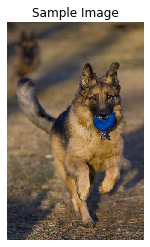

In [ ]:
get_prediction()

In [ ]:
original, processed, caption = next(iter(test_generator))
encoder.eval()
decoder.eval()
i = encoder(processed.to(device))
de = decoder(i, caption.to(device))

actual = caption[0].numpy()
aided_prediction = de.argmax(dim = 2)[0].to('cpu').numpy()

print("Actual:")
print(" ".join([ix_to_word[i] for i in actual]))
print("Aided Prediction")
print(" ".join([ix_to_word[i] for i in aided_prediction]))

print(actual)
print(aided_prediction)

Actual:
<startseq> two skinny dogs are running towards camera across a grassy <endseq>
Aided Prediction
<startseq> a dogs dogs are running through the other a grassy <endseq>
[  1  47 572  48  32 114 223 342 454   4 115   2]
[  1   4  48  48  32 114 119  24  38   4 115   2]


In [ ]:
# # cumulative BLEU scores
# def get_BLEU(reference, predicted):
#   onegram_cumsum = sentence_bleu(reference, predicted, weights=(1, 0, 0, 0))
#   twogram_cumsum = sentence_bleu(reference, predicted, weights=(0.5, 0.5, 0, 0))
#   threegram_cumsum = sentence_bleu(reference, predicted, weights=(0.33, 0.33, 0.33, 0))
#   fourgram_cumsum = sentence_bleu(reference, predicted, weights=(0.25, 0.25, 0.25, 0.25))
#   return {'1g_BLEU':onegram_cumsum, '2g_BLEU':twogram_cumsum, '3g_BLEU':threegram_cumsum, '4g_BLEU':fourgram_cumsum}

In [ ]:
# class DecoderRNN(nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
#         super().__init__()
#         self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
#         self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.linear = nn.Linear(hidden_size, vocab_size)

#     def forward(self, features, captions):
#         # Remove end-token from all captions
#         captions = captions[:, :-1]
#         embeddings = self.embed(captions)
#         # pass embeddings to LSTM
#         hiddens, states = self.lstm(embeddings)
#         # merge features and output of LSTM - merged architecture
#         merged = torch.cat((features.unsqueeze(1), hiddens), dim=1)
#         # pass merged to final feed-forward network
#         outputs = self.linear(merged)
#         return outputs